In [10]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Uniform
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset 
from delphi.oracle import Left, Interval
import datetime

In [11]:
STORE_PATH = '/home/pstefanou/Gradient'
STORE_TABLE_NAME = 'grad'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/Gradient/8dd1120e-ead4-4153-95f5-5b7ce27e1709


Experiment Constants

In [12]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 10
LOWER, UPPER = -1, 1
PREDICATE = Left(Tensor([1.0]))

In [ ]:
# begin experiment
start = datetime.datetime.now()

# perform each experiment a total of 10 times
for iter_ in range(1):        
    for VAR in range(1, 21):
        # generate data
        W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))
        X = Uniform(0, 1).sample(ch.Size([NUM_SAMPLES, DIMS]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([VAR]))).sample(ch.Size([NUM_SAMPLES]))
        # truncate
        indices = PREDICATE(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]

        # empirical linear regression
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/NUM_SAMPLES]), 
            'phi': PREDICATE, 
            'epochs': 10,
            'num_workers': 1, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'var_lr': 1e-2,
            'var': emp_var,
            'lr': 1e-1,
            'shuffle': True, 
            'tol': 1e-1,
        })


        # truncated linear regression with known noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False) # dataset 
        S = DataLoader(data, batch_size=args.batch_size, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, var=args.var, device=args.device)
        results = trunc_reg.fit(S)
        w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

        # truncated linear regression with unknown noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True) # dataset 
        S = DataLoader(data, batch_size=args.batch_size, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, device=args.device)
        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach().cpu()
        w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

        # calculate metrics 
        real_params, ols_params, unknown_params, known_params = ch.cat([W, W0]), ch.cat([data.w, data.w0.unsqueeze(0)]), ch.cat([w, w0]), ch.cat([w_.t(), w0_.unsqueeze(0)])
        unknown_param_mse, ols_param_mse, known_param_mse = mean_squared_error(unknown_params, real_params), mean_squared_error(ols_params, real_params), mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(VAR), 
        })

# end experiment
end = datetime.datetime.now()
print("time delta: {}".format(end - start))

# close store
store.close()

Epoch:1 | Score tensor([0.0294, 0.0575, 0.1036, 0.0731, 0.0823, 0.0454, 0.0688, 0.0726, 0.0518,
        0.0591, 0.1341]) 
Epoch:1 | Score tensor([0.0294, 0.0575, 0.1036, 0.0731, 0.0823, 0.0454, 0.0688, 0.0726, 0.0518,
        0.0591, 0.1341]) 
Epoch:1 | Score tensor([0.0495, 0.0912, 0.1007, 0.0835, 0.0888, 0.0501, 0.0717, 0.0715, 0.0548,
        0.0748, 0.1476]) 
Epoch:1 | Score tensor([0.0495, 0.0912, 0.1007, 0.0835, 0.0888, 0.0501, 0.0717, 0.0715, 0.0548,
        0.0748, 0.1476]) 
Epoch:1 | Score tensor([0.0519, 0.0714, 0.0717, 0.0615, 0.0707, 0.0452, 0.0629, 0.0587, 0.0466,
        0.0548, 0.1127]) 
Epoch:1 | Score tensor([0.0519, 0.0714, 0.0717, 0.0615, 0.0707, 0.0452, 0.0629, 0.0587, 0.0466,
        0.0548, 0.1127]) 
Epoch:1 | Score tensor([0.0571, 0.0775, 0.0834, 0.0696, 0.0701, 0.0454, 0.0674, 0.0634, 0.0566,
        0.0602, 0.1260]) 
Epoch:1 | Score tensor([0.0571, 0.0775, 0.0834, 0.0696, 0.0701, 0.0454, 0.0674, 0.0634, 0.0566,
        0.0602, 0.1260]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([ 0.0846,  0.0808,  0.0713,  0.0712,  0.0596,  0.0626,  0.0793,  0.0729,
         0.0692,  0.0690,  0.1472, -0.2169]) 
 | Loss 0.1831 ||: 100%|██████████| 12/12 [00:00<00:00, 67.41it/s]
Epoch:2 | Score tensor([ 0.1631,  0.1800,  0.1026,  0.0967,  0.0969,  0.1284,  0.1250,  0.1378,
         0.1218,  0.0963,  0.2494, -0.3845]) 
Epoch:2 | Score tensor([ 0.1631,  0.1800,  0.1026,  0.0967,  0.0969,  0.1284,  0.1250,  0.1378,
         0.1218,  0.0963,  0.2494, -0.3845]) 
Epoch:2 | Score tensor([ 0.0785,  0.0881,  0.0823,  0.0297,  0.0569,  0.0662,  0.0798,  0.0824,
         0.0736,  0.0551,  0.1347, -0.1316]) 
Epoch:2 | Score tensor([ 0.0785,  0.0881,  0.0823,  0.0297,  0.0569,  0.0662,  0.0798,  0.0824,
         0.0736,  0.0551,  0.1347, -0.1316]) 
Epoch:2 | Score tensor([ 0.0796,  0.0951,  0.0968,  0.0415,  0.0559,  0.0716,  0.0739,  0.0779,
         0.0867,  0.0646,  0.1472, -0.1659]) 
Epoch:2 | Score tensor([ 0.0796,  0.0951,  0.0968,  0.0415,  0.0559,  0.0716,  0.

Epoch:1 | Score tensor([0.0973, 0.0842, 0.0918, 0.0936, 0.0866, 0.0890, 0.0805, 0.0992, 0.0876,
        0.0897, 0.1714]) 
Epoch:1 | Score tensor([0.0973, 0.0842, 0.0918, 0.0936, 0.0866, 0.0890, 0.0805, 0.0992, 0.0876,
        0.0897, 0.1714]) 
Epoch:1 | Score tensor([0.0932, 0.0833, 0.0917, 0.0926, 0.0850, 0.0856, 0.0816, 0.0981, 0.0863,
        0.0872, 0.1692]) 
Epoch:1 | Score tensor([0.0932, 0.0833, 0.0917, 0.0926, 0.0850, 0.0856, 0.0816, 0.0981, 0.0863,
        0.0872, 0.1692]) 
Epoch:1 | Score tensor([0.0937, 0.0869, 0.0946, 0.0938, 0.0860, 0.0897, 0.0856, 0.1017, 0.0887,
        0.0918, 0.1760]) 
Epoch:1 | Score tensor([0.0937, 0.0869, 0.0946, 0.0938, 0.0860, 0.0897, 0.0856, 0.1017, 0.0887,
        0.0918, 0.1760]) 
Epoch:1 | Score tensor([0.0913, 0.0842, 0.0942, 0.0925, 0.0810, 0.0860, 0.0820, 0.0976, 0.0880,
        0.0889, 0.1706]) 
Epoch:1 | Score tensor([0.0913, 0.0842, 0.0942, 0.0925, 0.0810, 0.0860, 0.0820, 0.0976, 0.0880,
        0.0889, 0.1706]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0986, 0.1037, 0.0462, 0.1054, 0.1031, 0.0955, 0.1209, 0.1326, 0.1092,
        0.1319, 0.2135]) 
Epoch:2 | Score tensor([0.0986, 0.1037, 0.0462, 0.1054, 0.1031, 0.0955, 0.1209, 0.1326, 0.1092,
        0.1319, 0.2135]) 
Epoch:2 | Score tensor([0.0944, 0.0881, 0.0453, 0.0926, 0.0863, 0.0870, 0.0984, 0.1097, 0.0992,
        0.1085, 0.1820]) 
Epoch:2 | Score tensor([0.0944, 0.0881, 0.0453, 0.0926, 0.0863, 0.0870, 0.0984, 0.1097, 0.0992,
        0.1085, 0.1820]) 
Epoch:2 | Score tensor([0.0884, 0.0871, 0.0494, 0.0895, 0.0880, 0.0859, 0.1069, 0.1013, 0.0910,
        0.0959, 0.1768]) 
Epoch:2 | Score tensor([0.0884, 0.0871, 0.0494, 0.0895, 0.0880, 0.0859, 0.1069, 0.1013, 0.0910,
        0.0959, 0.1768]) 
Epoch:2 | Score tensor([0.1001, 0.0922, 0.0657, 0.1011, 0.0949, 0.0941, 0.1122, 0.1080, 0.0920,
        0.0905, 0.1834]) 
Epoch:2 | Score tensor([0.1001, 0.0922, 0.0657, 0.1011, 0.0949, 0.0941, 0.1122, 0.1080, 0.0920,
        0.0905, 0.1834]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.0794,  0.0775,  0.0860,  0.0894,  0.0760,  0.0754,  0.0806,  0.0713,
         0.0804,  0.0781,  0.1581, -0.1965]) 
Epoch:1 | Score tensor([ 0.0784,  0.0745,  0.0854,  0.0888,  0.0732,  0.0735,  0.0791,  0.0707,
         0.0784,  0.0797,  0.1543, -0.1911]) 
Epoch:1 | Score tensor([ 0.0784,  0.0745,  0.0854,  0.0888,  0.0732,  0.0735,  0.0791,  0.0707,
         0.0784,  0.0797,  0.1543, -0.1911]) 
Epoch:1 | Score tensor([ 0.0825,  0.0811,  0.0958,  0.0959,  0.0788,  0.0812,  0.0884,  0.0740,
         0.0845,  0.0864,  0.1673, -0.2333]) 
Epoch:1 | Score tensor([ 0.0825,  0.0811,  0.0958,  0.0959,  0.0788,  0.0812,  0.0884,  0.0740,
         0.0845,  0.0864,  0.1673, -0.2333]) 
Epoch:1 | Score tensor([ 0.0805,  0.0774,  0.0939,  0.0917,  0.0822,  0.0826,  0.0903,  0.0739,
         0.0840,  0.0863,  0.1662, -0.2287]) 
Epoch:1 | Score tensor([ 0.0805,  0.0774,  0.0939,  0.0917,  0.0822,  0.0826,  0.0903,  0.0739,
         0.0840,  0.0863,  0.1662, -0.2287]) 
Epoch:

Epoch:2 | Score tensor([ 0.0589,  0.0588,  0.0691,  0.0812,  0.0514,  0.0849,  0.0463,  0.0932,
         0.0900,  0.0669,  0.1448, -0.2183]) 
Epoch:2 | Score tensor([ 0.0595,  0.0514,  0.0612,  0.0787,  0.0595,  0.0844,  0.0578,  0.0850,
         0.0905,  0.0781,  0.1423, -0.2024]) 
Epoch:2 | Score tensor([ 0.0595,  0.0514,  0.0612,  0.0787,  0.0595,  0.0844,  0.0578,  0.0850,
         0.0905,  0.0781,  0.1423, -0.2024]) 
Epoch:2 | Score tensor([ 0.0617,  0.0546,  0.0580,  0.0731,  0.0495,  0.0828,  0.0547,  0.0756,
         0.0948,  0.0758,  0.1315, -0.1829]) 
Epoch:2 | Score tensor([ 0.0617,  0.0546,  0.0580,  0.0731,  0.0495,  0.0828,  0.0547,  0.0756,
         0.0948,  0.0758,  0.1315, -0.1829]) 
Epoch:2 | Score tensor([ 0.0781,  0.0740,  0.0718,  0.0865,  0.0569,  0.0947,  0.0699,  0.0924,
         0.1034,  0.0868,  0.1565, -0.2563]) 
Epoch:2 | Score tensor([ 0.0781,  0.0740,  0.0718,  0.0865,  0.0569,  0.0947,  0.0699,  0.0924,
         0.1034,  0.0868,  0.1565, -0.2563]) 
Epoch:

Epoch:1 | Score tensor([0.1145, 0.1206, 0.1236, 0.1191, 0.1158, 0.1176, 0.1146, 0.1208, 0.1217,
        0.1215, 0.2349]) 
Epoch:1 | Score tensor([0.1160, 0.1187, 0.1239, 0.1181, 0.1150, 0.1171, 0.1148, 0.1204, 0.1210,
        0.1209, 0.2342]) 
Epoch:1 | Score tensor([0.1160, 0.1187, 0.1239, 0.1181, 0.1150, 0.1171, 0.1148, 0.1204, 0.1210,
        0.1209, 0.2342]) 
Epoch:1 | Score tensor([0.1092, 0.1117, 0.1149, 0.1127, 0.1081, 0.1102, 0.1089, 0.1150, 0.1150,
        0.1137, 0.2215]) 
Epoch:1 | Score tensor([0.1092, 0.1117, 0.1149, 0.1127, 0.1081, 0.1102, 0.1089, 0.1150, 0.1150,
        0.1137, 0.2215]) 
Epoch:1 | Score tensor([0.1137, 0.1180, 0.1186, 0.1178, 0.1135, 0.1130, 0.1125, 0.1187, 0.1195,
        0.1193, 0.2302]) 
Epoch:1 | Score tensor([0.1137, 0.1180, 0.1186, 0.1178, 0.1135, 0.1130, 0.1125, 0.1187, 0.1195,
        0.1193, 0.2302]) 
Epoch:1 | Score tensor([0.1134, 0.1189, 0.1172, 0.1184, 0.1136, 0.1152, 0.1146, 0.1196, 0.1180,
        0.1187, 0.2315]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0544, 0.0598, 0.0552, 0.0587, 0.0639, 0.0623, 0.0588, 0.0582, 0.0733,
        0.0668, 0.1300]) 
Epoch:2 | Score tensor([0.0544, 0.0598, 0.0552, 0.0587, 0.0639, 0.0623, 0.0588, 0.0582, 0.0733,
        0.0668, 0.1300]) 
Epoch:2 | Score tensor([0.0465, 0.0485, 0.0490, 0.0500, 0.0594, 0.0525, 0.0499, 0.0462, 0.0635,
        0.0590, 0.1145]) 
Epoch:2 | Score tensor([0.0465, 0.0485, 0.0490, 0.0500, 0.0594, 0.0525, 0.0499, 0.0462, 0.0635,
        0.0590, 0.1145]) 
Epoch:2 | Score tensor([0.0465, 0.0485, 0.0490, 0.0500, 0.0594, 0.0525, 0.0499, 0.0462, 0.0635,
        0.0590, 0.1145]) 
Epoch:2 | Score tensor([0.0499, 0.0511, 0.0559, 0.0561, 0.0630, 0.0593, 0.0554, 0.0495, 0.0672,
        0.0609, 0.1246]) 
Epoch:2 | Score tensor([0.0499, 0.0511, 0.0559, 0.0561, 0.0630, 0.0593, 0.0554, 0.0495, 0.0672,
        0.0609, 0.1246]) 
Epoch:2 | Score tensor([0.0454, 0.0494, 0.0539, 0.0510, 0.0598, 0.0572, 0.0545, 0.0475, 0.0620,
        0.0565, 0.1180]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.0985,  0.1159,  0.1073,  0.0961,  0.0942,  0.1073,  0.1034,  0.1011,
         0.0904,  0.1018,  0.1992, -0.3192]) 
Epoch:1 | Score tensor([ 0.0985,  0.1159,  0.1073,  0.0961,  0.0942,  0.1073,  0.1034,  0.1011,
         0.0904,  0.1018,  0.1992, -0.3192]) 
Epoch:1 | Score tensor([ 0.0986,  0.1146,  0.1067,  0.0984,  0.0928,  0.1061,  0.1057,  0.1040,
         0.0890,  0.1009,  0.2008, -0.3279]) 
Epoch:1 | Score tensor([ 0.0986,  0.1146,  0.1067,  0.0984,  0.0928,  0.1061,  0.1057,  0.1040,
         0.0890,  0.1009,  0.2008, -0.3279]) 
Epoch:1 | Score tensor([ 0.0953,  0.1125,  0.1046,  0.0921,  0.0943,  0.1060,  0.1018,  0.1016,
         0.0866,  0.0973,  0.1960, -0.2968]) 
Epoch:1 | Score tensor([ 0.0953,  0.1125,  0.1046,  0.0921,  0.0943,  0.1060,  0.1018,  0.1016,
         0.0866,  0.0973,  0.1960, -0.2968]) 
Epoch:1 | Score tensor([ 0.0984,  0.1185,  0.1097,  0.0964,  0.0986,  0.1060,  0.1060,  0.1044,
         0.0891,  0.1010,  0.2020, -0.3142]) 
Epoch:

Epoch:1 | Score tensor([0.1173, 0.1111, 0.1085, 0.1217, 0.1308, 0.0829, 0.1231, 0.1271, 0.1244,
        0.1186, 0.2444]) 
Epoch:1 | Score tensor([0.1173, 0.1111, 0.1085, 0.1217, 0.1308, 0.0829, 0.1231, 0.1271, 0.1244,
        0.1186, 0.2444]) 
Epoch:1 | Score tensor([0.1312, 0.1146, 0.1242, 0.1388, 0.1302, 0.1085, 0.1145, 0.1490, 0.1286,
        0.1375, 0.2732]) 
Epoch:1 | Score tensor([0.1312, 0.1146, 0.1242, 0.1388, 0.1302, 0.1085, 0.1145, 0.1490, 0.1286,
        0.1375, 0.2732]) 
Epoch:1 | Score tensor([0.1201, 0.1109, 0.1130, 0.1234, 0.1333, 0.1146, 0.1048, 0.1339, 0.1258,
        0.1289, 0.2580]) 
Epoch:1 | Score tensor([0.1201, 0.1109, 0.1130, 0.1234, 0.1333, 0.1146, 0.1048, 0.1339, 0.1258,
        0.1289, 0.2580]) 
Epoch:1 | Score tensor([0.1260, 0.1258, 0.1136, 0.1216, 0.1376, 0.1179, 0.1139, 0.1358, 0.1237,
        0.1341, 0.2588]) 
Epoch:1 | Score tensor([0.1260, 0.1258, 0.1136, 0.1216, 0.1376, 0.1179, 0.1139, 0.1358, 0.1237,
        0.1341, 0.2588]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([ 0.1451,  0.1541,  0.1582,  0.1836,  0.1527,  0.1604,  0.1754,  0.1819,
         0.0957,  0.1581,  0.3442, -0.6667]) 
Epoch:2 | Score tensor([ 0.1451,  0.1541,  0.1582,  0.1836,  0.1527,  0.1604,  0.1754,  0.1819,
         0.0957,  0.1581,  0.3442, -0.6667]) 
Epoch:2 | Score tensor([ 0.1220,  0.1069,  0.1192,  0.1439,  0.1271,  0.1352,  0.1529,  0.1474,
         0.0878,  0.1289,  0.2644, -0.4725]) 
Epoch:2 | Score tensor([ 0.1220,  0.1069,  0.1192,  0.1439,  0.1271,  0.1352,  0.1529,  0.1474,
         0.0878,  0.1289,  0.2644, -0.4725]) 
Epoch:2 | Score tensor([ 0.0912,  0.0995,  0.1132,  0.1207,  0.1071,  0.1134,  0.1345,  0.1162,
         0.0703,  0.1061,  0.2267, -0.3718]) 
Epoch:2 | Score tensor([ 0.0912,  0.0995,  0.1132,  0.1207,  0.1071,  0.1134,  0.1345,  0.1162,
         0.0703,  0.1061,  0.2267, -0.3718]) 
Epoch:2 | Score tensor([ 0.0642,  0.0645,  0.0876,  0.0852,  0.0834,  0.0868,  0.1033,  0.0948,
         0.0531,  0.0913,  0.1681, -0.2133]) 
Epoch:

Epoch:1 | Score tensor([0.1316, 0.1269, 0.1310, 0.1326, 0.1314, 0.1188, 0.1333, 0.1227, 0.1269,
        0.1365, 0.2579]) 
Epoch:1 | Score tensor([0.1316, 0.1269, 0.1310, 0.1326, 0.1314, 0.1188, 0.1333, 0.1227, 0.1269,
        0.1365, 0.2579]) 
Epoch:1 | Score tensor([0.1322, 0.1279, 0.1306, 0.1351, 0.1332, 0.1222, 0.1325, 0.1244, 0.1266,
        0.1384, 0.2618]) 
Epoch:1 | Score tensor([0.1322, 0.1279, 0.1306, 0.1351, 0.1332, 0.1222, 0.1325, 0.1244, 0.1266,
        0.1384, 0.2618]) 
Epoch:1 | Score tensor([0.1289, 0.1303, 0.1264, 0.1363, 0.1282, 0.1195, 0.1292, 0.1240, 0.1256,
        0.1309, 0.2548]) 
Epoch:1 | Score tensor([0.1289, 0.1303, 0.1264, 0.1363, 0.1282, 0.1195, 0.1292, 0.1240, 0.1256,
        0.1309, 0.2548]) 
Epoch:1 | Score tensor([0.1325, 0.1339, 0.1306, 0.1426, 0.1314, 0.1272, 0.1367, 0.1306, 0.1277,
        0.1349, 0.2634]) 
Epoch:1 | Score tensor([0.1325, 0.1339, 0.1306, 0.1426, 0.1314, 0.1272, 0.1367, 0.1306, 0.1277,
        0.1349, 0.2634]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([ 0.1034,  0.1325,  0.1116,  0.1123,  0.0893,  0.0990,  0.1153,  0.1129,
         0.1195,  0.1168,  0.2352, -0.3530]) 
Epoch:1 | Score tensor([ 0.1034,  0.1325,  0.1116,  0.1123,  0.0893,  0.0990,  0.1153,  0.1129,
         0.1195,  0.1168,  0.2352, -0.3530]) 
Epoch:1 | Score tensor([ 0.1194,  0.1543,  0.1160,  0.1343,  0.1158,  0.1191,  0.1403,  0.1288,
         0.1393,  0.1464,  0.2637, -0.4601]) 
Epoch:1 | Score tensor([ 0.1194,  0.1543,  0.1160,  0.1343,  0.1158,  0.1191,  0.1403,  0.1288,
         0.1393,  0.1464,  0.2637, -0.4601]) 
Epoch:1 | Score tensor([ 0.1194,  0.1543,  0.1160,  0.1343,  0.1158,  0.1191,  0.1403,  0.1288,
         0.1393,  0.1464,  0.2637, -0.4601]) 
Epoch:1 | Score tensor([ 0.1031,  0.1406,  0.1208,  0.1330,  0.1134,  0.1113,  0.1137,  0.1232,
         0.1222,  0.1315,  0.2503, -0.4065]) 
Epoch:1 | Score tensor([ 0.1031,  0.1406,  0.1208,  0.1330,  0.1134,  0.1113,  0.1137,  0.1232,
         0.1222,  0.1315,  0.2503, -0.4065]) 
Epoch:

Epoch:1 | Score tensor([ 0.1466,  0.1464,  0.1382,  0.1462,  0.1401,  0.1363,  0.1379,  0.1449,
         0.1463,  0.1555,  0.2875, -0.5435]) 
 | Loss 0.8116 ||: 100%|██████████| 31/31 [00:00<00:00, 70.73it/s]
Epoch:2 | Score tensor([ 0.2144,  0.1073,  0.1260,  0.1617,  0.1522,  0.1186,  0.2002,  0.1131,
         0.1705,  0.1503,  0.2912, -0.8288]) 
Epoch:2 | Score tensor([ 0.2144,  0.1073,  0.1260,  0.1617,  0.1522,  0.1186,  0.2002,  0.1131,
         0.1705,  0.1503,  0.2912, -0.8288]) 
Epoch:2 | Score tensor([ 0.1795,  0.0715,  0.1679,  0.1836,  0.1516,  0.1388,  0.1039,  0.1123,
         0.1538,  0.1454,  0.2533, -0.4938]) 
Epoch:2 | Score tensor([ 0.1795,  0.0715,  0.1679,  0.1836,  0.1516,  0.1388,  0.1039,  0.1123,
         0.1538,  0.1454,  0.2533, -0.4938]) 
Epoch:2 | Score tensor([ 0.1307,  0.0970,  0.1337,  0.1580,  0.1566,  0.1219,  0.1011,  0.1049,
         0.1277,  0.1554,  0.2459, -0.4591]) 
Epoch:2 | Score tensor([ 0.1307,  0.0970,  0.1337,  0.1580,  0.1566,  0.1219,  0.

Epoch:1 | Score tensor([0.1506, 0.1371, 0.1225, 0.1487, 0.1325, 0.1302, 0.1080, 0.1461, 0.1231,
        0.1180, 0.2606]) 
Epoch:1 | Score tensor([0.1506, 0.1371, 0.1225, 0.1487, 0.1325, 0.1302, 0.1080, 0.1461, 0.1231,
        0.1180, 0.2606]) 
Epoch:1 | Score tensor([0.1527, 0.1397, 0.1216, 0.1473, 0.1315, 0.1262, 0.1070, 0.1448, 0.1238,
        0.1168, 0.2584]) 
Epoch:1 | Score tensor([0.1527, 0.1397, 0.1216, 0.1473, 0.1315, 0.1262, 0.1070, 0.1448, 0.1238,
        0.1168, 0.2584]) 
Epoch:1 | Score tensor([0.1554, 0.1464, 0.1280, 0.1541, 0.1343, 0.1367, 0.1146, 0.1540, 0.1307,
        0.1249, 0.2732]) 
Epoch:1 | Score tensor([0.1554, 0.1464, 0.1280, 0.1541, 0.1343, 0.1367, 0.1146, 0.1540, 0.1307,
        0.1249, 0.2732]) 
Epoch:1 | Score tensor([0.1464, 0.1349, 0.1230, 0.1418, 0.1233, 0.1276, 0.1042, 0.1447, 0.1275,
        0.1188, 0.2538]) 
Epoch:1 | Score tensor([0.1464, 0.1349, 0.1230, 0.1418, 0.1233, 0.1276, 0.1042, 0.1447, 0.1275,
        0.1188, 0.2538]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1616, 0.1625, 0.1596, 0.1613, 0.1597, 0.1613, 0.1560, 0.1590, 0.1607,
        0.1544, 0.3166]) 
Epoch:1 | Score tensor([0.1600, 0.1621, 0.1574, 0.1567, 0.1557, 0.1584, 0.1550, 0.1580, 0.1590,
        0.1527, 0.3118]) 
Epoch:1 | Score tensor([0.1600, 0.1621, 0.1574, 0.1567, 0.1557, 0.1584, 0.1550, 0.1580, 0.1590,
        0.1527, 0.3118]) 
Epoch:1 | Score tensor([0.1569, 0.1595, 0.1567, 0.1561, 0.1527, 0.1565, 0.1528, 0.1553, 0.1568,
        0.1512, 0.3087]) 
Epoch:1 | Score tensor([0.1569, 0.1595, 0.1567, 0.1561, 0.1527, 0.1565, 0.1528, 0.1553, 0.1568,
        0.1512, 0.3087]) 
Epoch:1 | Score tensor([0.1571, 0.1584, 0.1544, 0.1548, 0.1508, 0.1563, 0.1534, 0.1553, 0.1549,
        0.1499, 0.3073]) 
Epoch:1 | Score tensor([0.1571, 0.1584, 0.1544, 0.1548, 0.1508, 0.1563, 0.1534, 0.1553, 0.1549,
        0.1499, 0.3073]) 
Epoch:1 | Score tensor([0.1575, 0.1603, 0.1565, 0.1567, 0.1525, 0.1576, 0.1541, 0.1570, 0.1560,
        0.1522, 0.3100]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([ 0.1599,  0.1435,  0.1450,  0.1264,  0.1504,  0.1174,  0.1579,  0.1484,
         0.1649,  0.1757,  0.2887, -0.5519]) 
Epoch:1 | Score tensor([ 0.1599,  0.1435,  0.1450,  0.1264,  0.1504,  0.1174,  0.1579,  0.1484,
         0.1649,  0.1757,  0.2887, -0.5519]) 
Epoch:1 | Score tensor([ 0.1525,  0.1368,  0.1355,  0.1148,  0.1396,  0.1137,  0.1454,  0.1382,
         0.1552,  0.1647,  0.2710, -0.4855]) 
Epoch:1 | Score tensor([ 0.1525,  0.1368,  0.1355,  0.1148,  0.1396,  0.1137,  0.1454,  0.1382,
         0.1552,  0.1647,  0.2710, -0.4855]) 
Epoch:1 | Score tensor([ 0.1501,  0.1342,  0.1312,  0.1165,  0.1366,  0.1168,  0.1466,  0.1387,
         0.1511,  0.1601,  0.2665, -0.4583]) 
Epoch:1 | Score tensor([ 0.1501,  0.1342,  0.1312,  0.1165,  0.1366,  0.1168,  0.1466,  0.1387,
         0.1511,  0.1601,  0.2665, -0.4583]) 
Epoch:1 | Score tensor([ 0.1501,  0.1342,  0.1312,  0.1165,  0.1366,  0.1168,  0.1466,  0.1387,
         0.1511,  0.1601,  0.2665, -0.4583]) 
Epoch:

Epoch:1 | Score tensor([ 0.1648,  0.1645,  0.1614,  0.1649,  0.1629,  0.1570,  0.1662,  0.1601,
         0.1754,  0.1791,  0.3237, -0.7102]) 
Epoch:1 | Score tensor([ 0.1648,  0.1645,  0.1614,  0.1649,  0.1629,  0.1570,  0.1662,  0.1601,
         0.1754,  0.1791,  0.3237, -0.7102]) 
Epoch:1 | Score tensor([ 0.1669,  0.1655,  0.1634,  0.1635,  0.1642,  0.1609,  0.1652,  0.1610,
         0.1766,  0.1779,  0.3271, -0.7198]) 
Epoch:1 | Score tensor([ 0.1669,  0.1655,  0.1634,  0.1635,  0.1642,  0.1609,  0.1652,  0.1610,
         0.1766,  0.1779,  0.3271, -0.7198]) 
Epoch:1 | Score tensor([ 0.1617,  0.1626,  0.1600,  0.1571,  0.1585,  0.1547,  0.1595,  0.1562,
         0.1704,  0.1705,  0.3166, -0.6710]) 
Epoch:1 | Score tensor([ 0.1617,  0.1626,  0.1600,  0.1571,  0.1585,  0.1547,  0.1595,  0.1562,
         0.1704,  0.1705,  0.3166, -0.6710]) 
Epoch:1 | Score tensor([ 0.1579,  0.1572,  0.1532,  0.1517,  0.1548,  0.1480,  0.1559,  0.1498,
         0.1650,  0.1628,  0.3058, -0.6320]) 
Epoch:

Epoch:1 | Score tensor([0.1698, 0.1668, 0.1952, 0.1748, 0.1802, 0.1801, 0.1832, 0.1466, 0.1582,
        0.1716, 0.3398]) 
Epoch:1 | Score tensor([0.1733, 0.1703, 0.2001, 0.1766, 0.1816, 0.1810, 0.1799, 0.1504, 0.1673,
        0.1699, 0.3472]) 
Epoch:1 | Score tensor([0.1733, 0.1703, 0.2001, 0.1766, 0.1816, 0.1810, 0.1799, 0.1504, 0.1673,
        0.1699, 0.3472]) 
Epoch:1 | Score tensor([0.1756, 0.1720, 0.1966, 0.1748, 0.1792, 0.1787, 0.1818, 0.1550, 0.1626,
        0.1663, 0.3459]) 
Epoch:1 | Score tensor([0.1756, 0.1720, 0.1966, 0.1748, 0.1792, 0.1787, 0.1818, 0.1550, 0.1626,
        0.1663, 0.3459]) 
Epoch:1 | Score tensor([0.1723, 0.1715, 0.1900, 0.1756, 0.1755, 0.1745, 0.1817, 0.1520, 0.1630,
        0.1690, 0.3435]) 
Epoch:1 | Score tensor([0.1723, 0.1715, 0.1900, 0.1756, 0.1755, 0.1745, 0.1817, 0.1520, 0.1630,
        0.1690, 0.3435]) 
Epoch:1 | Score tensor([0.1721, 0.1711, 0.1829, 0.1773, 0.1755, 0.1714, 0.1802, 0.1517, 0.1614,
        0.1661, 0.3400]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0534, 0.0816, 0.0764, 0.0948, 0.0912, 0.0730, 0.0710, 0.0818, 0.0843,
        0.0890, 0.1670]) 
Epoch:2 | Score tensor([0.0534, 0.0816, 0.0764, 0.0948, 0.0912, 0.0730, 0.0710, 0.0818, 0.0843,
        0.0890, 0.1670]) 
Epoch:2 | Score tensor([0.0534, 0.0816, 0.0764, 0.0948, 0.0912, 0.0730, 0.0710, 0.0818, 0.0843,
        0.0890, 0.1670]) 
Epoch:2 | Score tensor([0.0558, 0.0815, 0.0765, 0.0920, 0.0845, 0.0742, 0.0656, 0.0849, 0.0846,
        0.0870, 0.1627]) 
Epoch:2 | Score tensor([0.0558, 0.0815, 0.0765, 0.0920, 0.0845, 0.0742, 0.0656, 0.0849, 0.0846,
        0.0870, 0.1627]) 
Epoch:2 | Score tensor([0.0607, 0.0850, 0.0752, 0.0896, 0.0825, 0.0746, 0.0705, 0.0855, 0.0863,
        0.0851, 0.1634]) 
Epoch:2 | Score tensor([0.0607, 0.0850, 0.0752, 0.0896, 0.0825, 0.0746, 0.0705, 0.0855, 0.0863,
        0.0851, 0.1634]) 
Epoch:2 | Score tensor([0.0546, 0.0771, 0.0709, 0.0812, 0.0704, 0.0639, 0.0637, 0.0784, 0.0786,
        0.0781, 0.1471]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1590,  0.1291,  0.1558,  0.1477,  0.1549,  0.1416,  0.1486,  0.1492,
         0.1396,  0.1387,  0.2975, -0.6318]) 
Epoch:1 | Score tensor([ 0.1660,  0.1322,  0.1614,  0.1531,  0.1602,  0.1373,  0.1533,  0.1539,
         0.1497,  0.1466,  0.3053, -0.6506]) 
Epoch:1 | Score tensor([ 0.1660,  0.1322,  0.1614,  0.1531,  0.1602,  0.1373,  0.1533,  0.1539,
         0.1497,  0.1466,  0.3053, -0.6506]) 
Epoch:1 | Score tensor([ 0.1616,  0.1259,  0.1579,  0.1512,  0.1556,  0.1302,  0.1492,  0.1488,
         0.1409,  0.1385,  0.2946, -0.5868]) 
Epoch:1 | Score tensor([ 0.1616,  0.1259,  0.1579,  0.1512,  0.1556,  0.1302,  0.1492,  0.1488,
         0.1409,  0.1385,  0.2946, -0.5868]) 
Epoch:1 | Score tensor([ 0.1578,  0.1291,  0.1622,  0.1496,  0.1539,  0.1320,  0.1505,  0.1470,
         0.1408,  0.1407,  0.2995, -0.5682]) 
Epoch:1 | Score tensor([ 0.1578,  0.1291,  0.1622,  0.1496,  0.1539,  0.1320,  0.1505,  0.1470,
         0.1408,  0.1407,  0.2995, -0.5682]) 
Epoch:

Epoch:2 | Score tensor([0.0617, 0.0439, 0.0324, 0.0510, 0.0205, 0.0300, 0.0527, 0.0317, 0.0484,
        0.0392, 0.1031, 0.0419]) 
Epoch:2 | Score tensor([0.0590, 0.0379, 0.0145, 0.0472, 0.0103, 0.0240, 0.0410, 0.0215, 0.0350,
        0.0352, 0.0809, 0.1297]) 
Epoch:2 | Score tensor([0.0590, 0.0379, 0.0145, 0.0472, 0.0103, 0.0240, 0.0410, 0.0215, 0.0350,
        0.0352, 0.0809, 0.1297]) 
Epoch:2 | Score tensor([0.0713, 0.0466, 0.0330, 0.0577, 0.0307, 0.0467, 0.0626, 0.0361, 0.0489,
        0.0451, 0.1091, 0.0420]) 
Epoch:2 | Score tensor([0.0713, 0.0466, 0.0330, 0.0577, 0.0307, 0.0467, 0.0626, 0.0361, 0.0489,
        0.0451, 0.1091, 0.0420]) 
Epoch:2 | Score tensor([ 0.0801,  0.0667,  0.0442,  0.0772,  0.0492,  0.0563,  0.0776,  0.0536,
         0.0633,  0.0525,  0.1335, -0.0445]) 
Epoch:2 | Score tensor([ 0.0801,  0.0667,  0.0442,  0.0772,  0.0492,  0.0563,  0.0776,  0.0536,
         0.0633,  0.0525,  0.1335, -0.0445]) 
Epoch:2 | Score tensor([0.0670, 0.0574, 0.0294, 0.0601, 0.0358, 0.

Epoch:1 | Score tensor([0.0561, 0.1883, 0.0641, 0.1522, 0.1216, 0.0816, 0.1443, 0.0680, 0.0892,
        0.2301, 0.2220]) 
Epoch:1 | Score tensor([0.1091, 0.1355, 0.1024, 0.1444, 0.1058, 0.1451, 0.1340, 0.0599, 0.1222,
        0.1969, 0.2277]) 
Epoch:1 | Score tensor([0.1091, 0.1355, 0.1024, 0.1444, 0.1058, 0.1451, 0.1340, 0.0599, 0.1222,
        0.1969, 0.2277]) 
Epoch:1 | Score tensor([0.1205, 0.1274, 0.1104, 0.1291, 0.1129, 0.1199, 0.1113, 0.1092, 0.1301,
        0.1616, 0.2381]) 
Epoch:1 | Score tensor([0.1205, 0.1274, 0.1104, 0.1291, 0.1129, 0.1199, 0.1113, 0.1092, 0.1301,
        0.1616, 0.2381]) 
Epoch:1 | Score tensor([0.1202, 0.1517, 0.1365, 0.1559, 0.1479, 0.1507, 0.1281, 0.1547, 0.1615,
        0.1574, 0.2945]) 
Epoch:1 | Score tensor([0.1202, 0.1517, 0.1365, 0.1559, 0.1479, 0.1507, 0.1281, 0.1547, 0.1615,
        0.1574, 0.2945]) 
Epoch:1 | Score tensor([0.1294, 0.1443, 0.1323, 0.1631, 0.1357, 0.1593, 0.1231, 0.1399, 0.1556,
        0.1549, 0.2929]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1562, 0.1596, 0.1563, 0.1649, 0.1581, 0.1527, 0.1562, 0.1597, 0.1584,
        0.1530, 0.3140]) 
Epoch:1 | Score tensor([0.1562, 0.1596, 0.1563, 0.1649, 0.1581, 0.1527, 0.1562, 0.1597, 0.1584,
        0.1530, 0.3140]) 
Epoch:1 | Score tensor([0.1562, 0.1596, 0.1563, 0.1649, 0.1581, 0.1527, 0.1562, 0.1597, 0.1584,
        0.1530, 0.3140]) 
 | Loss 1.2530 ||: 100%|██████████| 34/34 [00:00<00:00, 127.17it/s]
Epoch:2 | Score tensor([ 0.0248, -0.0513,  0.0736, -0.0164,  0.0884, -0.0178,  0.0776,  0.0850,
        -0.0130,  0.0926,  0.0775]) 
Epoch:2 | Score tensor([ 0.0248, -0.0513,  0.0736, -0.0164,  0.0884, -0.0178,  0.0776,  0.0850,
        -0.0130,  0.0926,  0.0775]) 
Epoch:2 | Score tensor([ 0.0248, -0.0513,  0.0736, -0.0164,  0.0884, -0.0178,  0.0776,  0.0850,
        -0.0130,  0.0926,  0.0775]) 
 | Loss 1.3093 ||:   0%|          | 0/34 [00:00<?, ?it/s]
Epoch:1 | Score tensor([ 0.1550,  0.1100,  0.1388,  0.1406,  0.1665,  0.1997,  0.1334,  0.0779,
         0.20

Epoch:1 | Score tensor([ 0.1516,  0.1444,  0.1518,  0.1518,  0.1277,  0.1355,  0.1223,  0.1308,
         0.1372,  0.1456,  0.2750, -0.5023]) 
Epoch:1 | Score tensor([ 0.1436,  0.1443,  0.1492,  0.1461,  0.1225,  0.1320,  0.1213,  0.1292,
         0.1354,  0.1397,  0.2691, -0.4810]) 
Epoch:1 | Score tensor([ 0.1436,  0.1443,  0.1492,  0.1461,  0.1225,  0.1320,  0.1213,  0.1292,
         0.1354,  0.1397,  0.2691, -0.4810]) 
Epoch:1 | Score tensor([ 0.1456,  0.1505,  0.1527,  0.1513,  0.1305,  0.1379,  0.1312,  0.1393,
         0.1426,  0.1477,  0.2828, -0.5423]) 
Epoch:1 | Score tensor([ 0.1456,  0.1505,  0.1527,  0.1513,  0.1305,  0.1379,  0.1312,  0.1393,
         0.1426,  0.1477,  0.2828, -0.5423]) 
Epoch:1 | Score tensor([ 0.1551,  0.1583,  0.1589,  0.1569,  0.1412,  0.1455,  0.1422,  0.1478,
         0.1478,  0.1512,  0.2968, -0.5972]) 
Epoch:1 | Score tensor([ 0.1551,  0.1583,  0.1589,  0.1569,  0.1412,  0.1455,  0.1422,  0.1478,
         0.1478,  0.1512,  0.2968, -0.5972]) 
Epoch:

Epoch:2 | Score tensor([0.0204, 0.0337, 0.0390, 0.0347, 0.0383, 0.0301, 0.0135, 0.0213, 0.0389,
        0.0435, 0.0659, 0.2498]) 
Epoch:2 | Score tensor([0.0166, 0.0348, 0.0402, 0.0325, 0.0367, 0.0307, 0.0155, 0.0195, 0.0439,
        0.0402, 0.0641, 0.2683]) 
Epoch:2 | Score tensor([0.0166, 0.0348, 0.0402, 0.0325, 0.0367, 0.0307, 0.0155, 0.0195, 0.0439,
        0.0402, 0.0641, 0.2683]) 
Epoch:2 | Score tensor([0.0210, 0.0313, 0.0435, 0.0349, 0.0405, 0.0290, 0.0149, 0.0175, 0.0459,
        0.0376, 0.0632, 0.2923]) 
Epoch:2 | Score tensor([0.0210, 0.0313, 0.0435, 0.0349, 0.0405, 0.0290, 0.0149, 0.0175, 0.0459,
        0.0376, 0.0632, 0.2923]) 
Epoch:2 | Score tensor([0.0172, 0.0305, 0.0380, 0.0344, 0.0329, 0.0283, 0.0131, 0.0152, 0.0402,
        0.0430, 0.0546, 0.3266]) 
Epoch:2 | Score tensor([0.0172, 0.0305, 0.0380, 0.0344, 0.0329, 0.0283, 0.0131, 0.0152, 0.0402,
        0.0430, 0.0546, 0.3266]) 
Epoch:2 | Score tensor([0.0225, 0.0322, 0.0394, 0.0394, 0.0393, 0.0318, 0.0158, 0.0182, 0.

Epoch:1 | Score tensor([0.1482, 0.1268, 0.1240, 0.1004, 0.1973, 0.1597, 0.1606, 0.2041, 0.1314,
        0.1445, 0.2983]) 
Epoch:1 | Score tensor([0.1540, 0.1442, 0.1232, 0.0931, 0.1905, 0.1423, 0.1584, 0.1889, 0.1377,
        0.1618, 0.2985]) 
Epoch:1 | Score tensor([0.1540, 0.1442, 0.1232, 0.0931, 0.1905, 0.1423, 0.1584, 0.1889, 0.1377,
        0.1618, 0.2985]) 
Epoch:1 | Score tensor([0.1462, 0.1384, 0.1277, 0.0944, 0.1832, 0.1242, 0.1555, 0.1645, 0.1436,
        0.1469, 0.2844]) 
Epoch:1 | Score tensor([0.1462, 0.1384, 0.1277, 0.0944, 0.1832, 0.1242, 0.1555, 0.1645, 0.1436,
        0.1469, 0.2844]) 
Epoch:1 | Score tensor([0.1700, 0.1465, 0.1477, 0.1231, 0.2095, 0.1570, 0.1767, 0.1761, 0.1589,
        0.1710, 0.3292]) 
Epoch:1 | Score tensor([0.1700, 0.1465, 0.1477, 0.1231, 0.2095, 0.1570, 0.1767, 0.1761, 0.1589,
        0.1710, 0.3292]) 
Epoch:1 | Score tensor([0.1767, 0.1565, 0.1474, 0.1295, 0.1954, 0.1558, 0.1697, 0.1857, 0.1620,
        0.1621, 0.3328]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1852, 0.1823, 0.1743, 0.1802, 0.1873, 0.1841, 0.1773, 0.1787, 0.1820,
        0.1829, 0.3636]) 
Epoch:1 | Score tensor([0.1852, 0.1823, 0.1743, 0.1802, 0.1873, 0.1841, 0.1773, 0.1787, 0.1820,
        0.1829, 0.3636]) 
Epoch:1 | Score tensor([0.1902, 0.1851, 0.1786, 0.1833, 0.1893, 0.1874, 0.1816, 0.1803, 0.1817,
        0.1862, 0.3695]) 
Epoch:1 | Score tensor([0.1902, 0.1851, 0.1786, 0.1833, 0.1893, 0.1874, 0.1816, 0.1803, 0.1817,
        0.1862, 0.3695]) 
Epoch:1 | Score tensor([0.1869, 0.1831, 0.1752, 0.1788, 0.1864, 0.1827, 0.1805, 0.1774, 0.1786,
        0.1823, 0.3633]) 
Epoch:1 | Score tensor([0.1869, 0.1831, 0.1752, 0.1788, 0.1864, 0.1827, 0.1805, 0.1774, 0.1786,
        0.1823, 0.3633]) 
Epoch:1 | Score tensor([0.1869, 0.1831, 0.1752, 0.1788, 0.1864, 0.1827, 0.1805, 0.1774, 0.1786,
        0.1823, 0.3633]) 
Epoch:1 | Score tensor([0.1854, 0.1800, 0.1769, 0.1783, 0.1875, 0.1841, 0.1808, 0.1773, 0.1794,
        0.1818, 0.3634]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([ 0.2312,  0.3203,  0.3704,  0.3154,  0.4160,  0.3917,  0.1474,  0.3007,
         0.2934,  0.3489,  0.5717, -1.8925]) 
Epoch:1 | Score tensor([ 0.2312,  0.3203,  0.3704,  0.3154,  0.4160,  0.3917,  0.1474,  0.3007,
         0.2934,  0.3489,  0.5717, -1.8925]) 
Epoch:1 | Score tensor([ 0.2317,  0.2554,  0.2351,  0.2763,  0.2763,  0.3736,  0.2247,  0.2628,
         0.2739,  0.3320,  0.5565, -1.5986]) 
Epoch:1 | Score tensor([ 0.2317,  0.2554,  0.2351,  0.2763,  0.2763,  0.3736,  0.2247,  0.2628,
         0.2739,  0.3320,  0.5565, -1.5986]) 
Epoch:1 | Score tensor([ 0.2018,  0.1860,  0.2035,  0.2450,  0.2187,  0.2816,  0.1934,  0.2677,
         0.2202,  0.2679,  0.4766, -1.2071]) 
Epoch:1 | Score tensor([ 0.2018,  0.1860,  0.2035,  0.2450,  0.2187,  0.2816,  0.1934,  0.2677,
         0.2202,  0.2679,  0.4766, -1.2071]) 
Epoch:1 | Score tensor([ 0.1762,  0.1825,  0.2191,  0.2109,  0.2156,  0.2637,  0.1783,  0.2539,
         0.2219,  0.2305,  0.4391, -1.0902]) 
Epoch:

Epoch:1 | Score tensor([ 0.1941,  0.1866,  0.1959,  0.2009,  0.1980,  0.2134,  0.2033,  0.1980,
         0.2047,  0.1981,  0.4089, -1.0629]) 
Epoch:1 | Score tensor([ 0.1908,  0.1917,  0.1913,  0.1971,  0.2003,  0.2154,  0.2022,  0.1979,
         0.2020,  0.1990,  0.4077, -1.0706]) 
Epoch:1 | Score tensor([ 0.1908,  0.1917,  0.1913,  0.1971,  0.2003,  0.2154,  0.2022,  0.1979,
         0.2020,  0.1990,  0.4077, -1.0706]) 
Epoch:1 | Score tensor([ 0.1866,  0.1871,  0.1840,  0.1887,  0.1912,  0.2064,  0.1953,  0.1861,
         0.1948,  0.1955,  0.3956, -1.0067]) 
Epoch:1 | Score tensor([ 0.1866,  0.1871,  0.1840,  0.1887,  0.1912,  0.2064,  0.1953,  0.1861,
         0.1948,  0.1955,  0.3956, -1.0067]) 
Epoch:1 | Score tensor([ 0.1866,  0.1871,  0.1840,  0.1887,  0.1912,  0.2064,  0.1953,  0.1861,
         0.1948,  0.1955,  0.3956, -1.0067]) 
Epoch:1 | Score tensor([ 0.1857,  0.1896,  0.1832,  0.1875,  0.1944,  0.2044,  0.1921,  0.1869,
         0.1942,  0.1984,  0.3972, -1.0012]) 
Epoch:

Epoch:2 | Score tensor([0.0344, 0.0443, 0.0204, 0.0398, 0.0397, 0.0570, 0.0296, 0.0426, 0.0408,
        0.0309, 0.0892, 0.2818]) 
Epoch:2 | Score tensor([0.0475, 0.0607, 0.0311, 0.0496, 0.0528, 0.0712, 0.0446, 0.0567, 0.0581,
        0.0425, 0.1110, 0.1815]) 
Epoch:2 | Score tensor([0.0475, 0.0607, 0.0311, 0.0496, 0.0528, 0.0712, 0.0446, 0.0567, 0.0581,
        0.0425, 0.1110, 0.1815]) 
Epoch:2 | Score tensor([0.0397, 0.0610, 0.0244, 0.0411, 0.0570, 0.0621, 0.0385, 0.0520, 0.0534,
        0.0318, 0.1021, 0.2148]) 
Epoch:2 | Score tensor([0.0397, 0.0610, 0.0244, 0.0411, 0.0570, 0.0621, 0.0385, 0.0520, 0.0534,
        0.0318, 0.1021, 0.2148]) 
Epoch:2 | Score tensor([0.0484, 0.0662, 0.0287, 0.0430, 0.0604, 0.0711, 0.0387, 0.0557, 0.0542,
        0.0325, 0.1146, 0.1541]) 
Epoch:2 | Score tensor([0.0484, 0.0662, 0.0287, 0.0430, 0.0604, 0.0711, 0.0387, 0.0557, 0.0542,
        0.0325, 0.1146, 0.1541]) 
Epoch:2 | Score tensor([0.0338, 0.0492, 0.0230, 0.0294, 0.0522, 0.0601, 0.0306, 0.0459, 0.

Epoch:2 | Score tensor([0.0177, 0.0214, 0.0375, 0.0205, 0.0199, 0.0316, 0.0241, 0.0226, 0.0187,
        0.0204, 0.0639, 0.2860]) 
Epoch:2 | Score tensor([0.0177, 0.0214, 0.0375, 0.0205, 0.0199, 0.0316, 0.0241, 0.0226, 0.0187,
        0.0204, 0.0639, 0.2860]) 
Epoch:2 | Score tensor([0.0204, 0.0229, 0.0373, 0.0218, 0.0185, 0.0312, 0.0288, 0.0226, 0.0206,
        0.0249, 0.0658, 0.2821]) 
Epoch:2 | Score tensor([0.0204, 0.0229, 0.0373, 0.0218, 0.0185, 0.0312, 0.0288, 0.0226, 0.0206,
        0.0249, 0.0658, 0.2821]) 
Epoch:2 | Score tensor([0.0206, 0.0172, 0.0365, 0.0215, 0.0178, 0.0299, 0.0289, 0.0212, 0.0193,
        0.0222, 0.0618, 0.2964]) 
Epoch:2 | Score tensor([0.0206, 0.0172, 0.0365, 0.0215, 0.0178, 0.0299, 0.0289, 0.0212, 0.0193,
        0.0222, 0.0618, 0.2964]) 
Epoch:2 | Score tensor([0.0189, 0.0146, 0.0347, 0.0191, 0.0154, 0.0287, 0.0268, 0.0181, 0.0162,
        0.0194, 0.0572, 0.3152]) 
Epoch:2 | Score tensor([0.0189, 0.0146, 0.0347, 0.0191, 0.0154, 0.0287, 0.0268, 0.0181, 0.

Epoch:1 | Score tensor([0.2027, 0.1878, 0.1720, 0.1809, 0.1879, 0.1939, 0.1771, 0.1913, 0.1808,
        0.1966, 0.3759]) 
Epoch:1 | Score tensor([0.2027, 0.1878, 0.1720, 0.1809, 0.1879, 0.1939, 0.1771, 0.1913, 0.1808,
        0.1966, 0.3759]) 
Epoch:1 | Score tensor([0.1997, 0.1858, 0.1763, 0.1799, 0.1834, 0.1924, 0.1723, 0.1924, 0.1773,
        0.1961, 0.3708]) 
Epoch:1 | Score tensor([0.1997, 0.1858, 0.1763, 0.1799, 0.1834, 0.1924, 0.1723, 0.1924, 0.1773,
        0.1961, 0.3708]) 
Epoch:1 | Score tensor([0.2027, 0.1847, 0.1811, 0.1889, 0.1851, 0.1929, 0.1780, 0.2034, 0.1790,
        0.1974, 0.3763]) 
Epoch:1 | Score tensor([0.2027, 0.1847, 0.1811, 0.1889, 0.1851, 0.1929, 0.1780, 0.2034, 0.1790,
        0.1974, 0.3763]) 
Epoch:1 | Score tensor([0.2021, 0.1852, 0.1826, 0.1917, 0.1887, 0.1920, 0.1771, 0.2061, 0.1827,
        0.2021, 0.3800]) 
Epoch:1 | Score tensor([0.2021, 0.1852, 0.1826, 0.1917, 0.1887, 0.1920, 0.1771, 0.2061, 0.1827,
        0.2021, 0.3800]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1938, 0.1938, 0.1823, 0.1898, 0.1930, 0.1902, 0.1821, 0.1924, 0.1858,
        0.1886, 0.3765]) 
Epoch:1 | Score tensor([0.1916, 0.1891, 0.1781, 0.1876, 0.1921, 0.1861, 0.1798, 0.1877, 0.1821,
        0.1855, 0.3712]) 
Epoch:1 | Score tensor([0.1916, 0.1891, 0.1781, 0.1876, 0.1921, 0.1861, 0.1798, 0.1877, 0.1821,
        0.1855, 0.3712]) 
Epoch:1 | Score tensor([0.1919, 0.1868, 0.1784, 0.1874, 0.1925, 0.1836, 0.1803, 0.1847, 0.1828,
        0.1837, 0.3693]) 
Epoch:1 | Score tensor([0.1919, 0.1868, 0.1784, 0.1874, 0.1925, 0.1836, 0.1803, 0.1847, 0.1828,
        0.1837, 0.3693]) 
Epoch:1 | Score tensor([0.1919, 0.1868, 0.1784, 0.1874, 0.1925, 0.1836, 0.1803, 0.1847, 0.1828,
        0.1837, 0.3693]) 
Epoch:1 | Score tensor([0.1899, 0.1845, 0.1769, 0.1855, 0.1880, 0.1812, 0.1798, 0.1824, 0.1813,
        0.1826, 0.3663]) 
Epoch:1 | Score tensor([0.1899, 0.1845, 0.1769, 0.1855, 0.1880, 0.1812, 0.1798, 0.1824, 0.1813,
        0.1826, 0.3663]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.1188, 0.0752, 0.0849, 0.0824, 0.0998, 0.1220, 0.0992, 0.0975, 0.0905,
        0.1041, 0.2029]) 
Epoch:2 | Score tensor([0.1178, 0.0841, 0.0917, 0.0855, 0.1047, 0.1202, 0.0960, 0.1016, 0.0954,
        0.1090, 0.2074]) 
Epoch:2 | Score tensor([0.1178, 0.0841, 0.0917, 0.0855, 0.1047, 0.1202, 0.0960, 0.1016, 0.0954,
        0.1090, 0.2074]) 
Epoch:2 | Score tensor([0.1036, 0.0762, 0.0724, 0.0698, 0.0938, 0.1160, 0.0852, 0.0995, 0.0819,
        0.0909, 0.1825]) 
Epoch:2 | Score tensor([0.1036, 0.0762, 0.0724, 0.0698, 0.0938, 0.1160, 0.0852, 0.0995, 0.0819,
        0.0909, 0.1825]) 
Epoch:2 | Score tensor([0.0916, 0.0616, 0.0635, 0.0614, 0.0802, 0.0930, 0.0724, 0.0789, 0.0754,
        0.0746, 0.1549]) 
Epoch:2 | Score tensor([0.0916, 0.0616, 0.0635, 0.0614, 0.0802, 0.0930, 0.0724, 0.0789, 0.0754,
        0.0746, 0.1549]) 
Epoch:2 | Score tensor([0.0846, 0.0504, 0.0573, 0.0596, 0.0688, 0.0808, 0.0631, 0.0659, 0.0682,
        0.0684, 0.1417]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1367,  0.1777,  0.1426,  0.1787,  0.1735,  0.1168,  0.1701,  0.1671,
         0.1302,  0.1978,  0.3232, -0.8267]) 
Epoch:1 | Score tensor([ 0.1365,  0.1672,  0.1345,  0.1695,  0.1660,  0.1035,  0.1615,  0.1610,
         0.1280,  0.1774,  0.3086, -0.7493]) 
Epoch:1 | Score tensor([ 0.1365,  0.1672,  0.1345,  0.1695,  0.1660,  0.1035,  0.1615,  0.1610,
         0.1280,  0.1774,  0.3086, -0.7493]) 
 | Loss 2.6788 ||:  21%|██        | 14/67 [00:00<00:00, 61.85it/s]

In [6]:
print("unknown mse: {}".format(unknown_param_mse))
print("ols mse: {}".format(ols_param_mse))
print("known mse: {}".format(known_param_mse))

unknown mse: 1.2790143489837646
ols mse: 1.2551058530807495
known mse: 1.1585770845413208


In [7]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 1/1 [00:00<00:00, 131.22it/s]


,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.396554,0.396554,0.396554,0.3133,1.0,3d4e86ae-9d89-4250-8ea5-3417a167a396
1,0.206597,0.206597,0.206597,0.7115,2.0,3d4e86ae-9d89-4250-8ea5-3417a167a396
2,0.755362,0.748822,0.755362,0.4185,3.0,3d4e86ae-9d89-4250-8ea5-3417a167a396
3,0.576552,0.600983,0.600983,0.1537,4.0,3d4e86ae-9d89-4250-8ea5-3417a167a396
4,0.735157,0.710190,0.735758,0.4574,5.0,3d4e86ae-9d89-4250-8ea5-3417a167a396


In [8]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

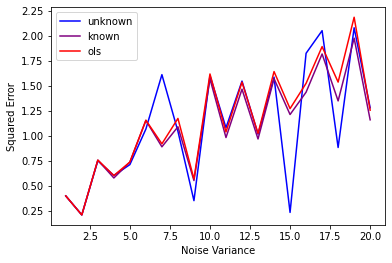

In [9]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

In [21]:
store.close()

In [ ]:
print("hi")

In [10]:
store.close()

In [22]:
reader = CollectionReader('/home/pstefanou/Uniform2/')
results = reader.df('uniform')

 60%|██████    | 3/5 [00:00<00:00, 187.94it/s]


OSError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1400, in H5F__open
    unable to open file
  File "H5Fint.c", line 1615, in H5F_open
    unable to lock the file
  File "H5FD.c", line 1640, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 941, in H5FD_sec2_lock
    unable to lock file, errno = 11, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file '/home/pstefanou/Uniform2/9eb85ee0-dcf6-4c9a-a1b7-94cc3558ba8d/store.h5'

In [23]:
results

,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.229495,0.229495,0.229495,0.3954,1.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
1,0.168892,0.167581,0.168892,0.7402,2.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
2,0.650567,0.676718,0.678642,0.0641,3.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
3,0.895550,0.874560,0.895550,0.2629,4.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
4,0.357972,0.403891,0.385633,0.4885,5.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
5,0.835289,0.924343,0.835289,0.6530,6.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
6,0.452985,0.489863,0.493153,0.4877,7.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
7,1.088347,1.136333,1.152218,0.3656,8.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
8,1.193646,0.996717,1.282450,0.3545,9.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
9,0.926922,255.613586,0.972060,0.4802,10.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80


In [21]:
reader.close()

ClosedFileError: /home/pstefanou/Uniform2/a5110297-3b99-46a1-a6fd-3c436d7caf34/store.h5 file is not open!